# Maximizing the ELBO

> In this post, we will cover the complete implementation of Variational AutoEncoder, which can optimize the ELBO objective function. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/fashion_mnist_generated.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from IPython.display import HTML, Image

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams['animation.embed_limit'] = 2**128

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Prior Distribution

$ \text{latent variable } z \sim N(0, I) = p(z) \\
 p(x \vert z) = \text{decoder}(z) \\
 x \sim p(x \vert z) $

### Approximating True Posterior distribution

$ \text{encoder }(x) = q(z \vert x) \simeq p(z \vert x) \\
 \begin{aligned} \log p(x) & \ge \mathbb{E}_{z \sim q(z \vert x)}[-\log q(z \vert x) + \log p(x \vert z)] \quad \leftarrow \text{maximizing this lower bound} \\
  &= - \mathrm{KL} (q(z \vert x) \vert \vert p(z)) + \mathbb{E}_{z \sim q(z \vert x)}[\log p(x \vert z)] \quad \leftarrow \text{Evidence Lower Bound (ELBO)} \end{aligned}$

### Sample Encoder Architecture

```python
latent_size = 2
event_shape = (28, 28, 1)

encoder = Sequential([
    Conv2D(8, (5, 5), strides=2, activation='tanh', input_shape=event_shape),
    Conv2D(8, (5, 5), strides=2, activatoin='tanh'),
    Flatten(),
    Dense(64, activation='tanh'),
    Dense(2 * latent_size),
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[..., :latent_size], scale_diag=tf.math.exp(t[..., latent_size:]))),
], name='encoder')

encoder(X_train[:16])
``` 

### Sample Decoder Architecture

Almose reverse order of Encoder.

```python
decoder = Sequential([
    Dense(64, activation='tanh', input_shape=(latent_size, )),
    Dense(128, activation='tanh'),
    Reshape((4, 4, 8)), # In order to put it in the form required by Conv2D layer
    Conv2DTranspose(8, (5, 5), strides=2, output_padding=1, activation='tanh'),
    Conv2DTranspose(8, (5, 5), strides=2, output_padding=1, activation='tanh'),
    Conv2D(1, (3, 3), padding='SAME'),
    Flatten(),
    tfpl.IndependentBernoulli(event_shape)
], name='decoder')

decoder(tf.random.normal([16, latent_size])
```

### Prior Distribution for zero-mean gaussian with identity covariance matrix
```python
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))
```

### ELBO objective function
 One way to implement ELBO function is to use Analytical computation of KL divergence.
 
```python
def loss_fn(X_true, approx_posterior, X_pred, prior_dist):
    """
    X_true: batch of data examples
    approx_posterior: the output of encoder
    X_pred: output of decoder
    prior_dist: Prior distribution
    """
    return tf.reduce_mean(tfd.kl_divergence(approx_posterior, prior_dist) - X_pred.log_prob(X_true))
```

The other way is using Monte Carlo Sampling instead of analyticall with the KL Divergence.

```python
def loss_fn(X_true, approx_posterior, X_pred, prior_dist):
    reconstruction_loss = -X_pred.log_prob(X_true)
    approx_posterior_sample = approx_posterior.sample()
    kl_approx = (approx_posterior.log_prob(approx_posterior_sample) - prior_dist.log_prob(approx_posterior_sample))
    return tf.reduce_mean(kl_approx + reconstruction_loss)
```

### Calculating Gradient of Loss function
```python
@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        approx_posterior = encoder(x)
        approx_posterior_sample = approx_posterior.sample()
        X_pred = decoder(approx_posterior_sample)
        current_loss = loss_fn(x, approx_posterior, X_pred, prior)
    grads = tape.gradient(current_loss, encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads
```

### Training Loop

```python
optimizer = tf.keras.optimizers.Adam()
for epoch in range(num_epochs):
    for train_batch in train_data:
        loss, grads = get_loss_and_grads(train_batch)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
```

### Test
```python
z = prior.sample(1) # (1, 2)
x = decoder(z).sample() # (1, 28, 28, 1)

X_encoded = encoder(X_sample)

def vae(inputs):
    approx_posterior = encoder(inputs)
    decoded = decoder(approx_posterior.sample())
    return decoded.sample()

reconstruction = vae(X_sample)
```

## Tutorial

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

$$
\begin{aligned}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[−\log q(Z | x) + \log p(x, Z)\big]\\
          &= - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] + \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big] 
\end{aligned}
$$

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape

In [4]:
# Import Fashion MNIST, make it a Tensorflow Dataset

(X_train, _), (X_test, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
example_X = X_test[:16]

batch_size = 64
X_train = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

In [5]:
# Define the encoding distribution, q(z | x)

latent_size = 2
event_shape = (28, 28)

encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2 * latent_size),
    tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :latent_size],
            scale_diag=tf.math.exp(t[..., latent_size:])
        )
    )
])

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [6]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiag

encoder(example_X)

<tfp.distributions.MultivariateNormalDiag 'sequential_distribution_lambda_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [7]:
# Define the decoding distribution, p(x | z)

decoder = Sequential([
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
    tfpl.IndependentBernoulli(event_shape)
])

In [8]:
# Pass a batch of examples to the decoder

decoder(tf.random.normal([16, latent_size]))

<tfp.distributions.Independent 'sequential_1_independent_bernoulli_IndependentBernoulli_Independentsequential_1_independent_bernoulli_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [9]:
# Define the prior, p(z) - a standard bivariate Gaussian
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

The loss function we need to estimate is
$$
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
$$
where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as
$$
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
$$

In [10]:
# Specify the loss function, an estimate of the -ELBO

def loss(x, encoding_dist, sampled_decoding_dist, prior):
    return tf.reduce_sum(
        tfd.kl_divergence(encoding_dist, prior) - sampled_decoding_dist.log_prob(x)
    )

In [11]:
# Define a function that returns the loss and its gradients

@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(x)
        sampled_z = encoding_dist.sample()
        sampled_decoding_dist = decoder(sampled_z)
        current_loss = loss(x, encoding_dist, sampled_decoding_dist, prior)
    grads = tape.gradient(current_loss, encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads

In [12]:
# Compile and train the model
num_epochs = 10
optimizer = tf.keras.optimizers.Adam()

for i in range(num_epochs):
    for train_batch in X_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i + 1, current_loss.numpy()))

-ELBO after epoch 1: 8990
-ELBO after epoch 2: 8858
-ELBO after epoch 3: 8782
-ELBO after epoch 4: 8820
-ELBO after epoch 5: 8716
-ELBO after epoch 6: 8664
-ELBO after epoch 7: 8727
-ELBO after epoch 8: 8667
-ELBO after epoch 9: 8810
-ELBO after epoch 10: 8675


In [13]:
# Connect encoder and decoder, compute a reconstruction

def vae(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.sample()

example_reconstruction = vae(example_X).numpy().squeeze()

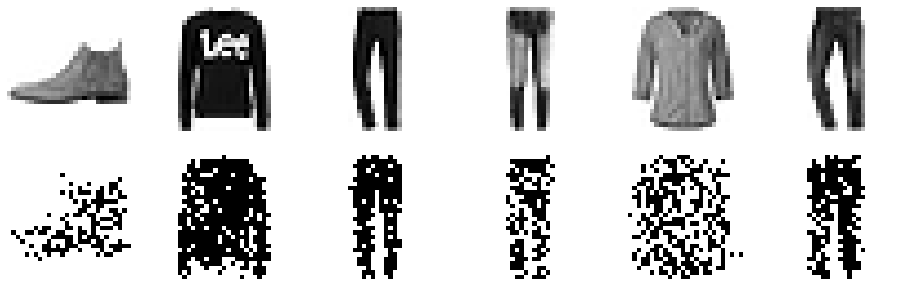

In [14]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

Since the model has lack of reconstruction from grayscale image, So using mean for reconstruction gets more satisfied results.

In [15]:
# Connect encoder and decoder, compute a reconstruction with mean

def vae_mean(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.mean()

example_reconstruction = vae_mean(example_X).numpy().squeeze()

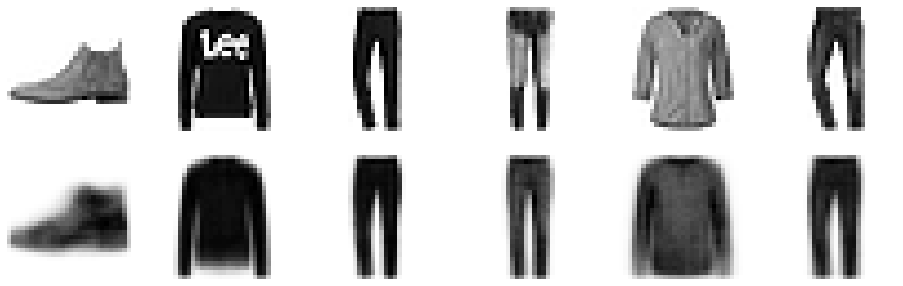

In [16]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [17]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = decoder(z).sample()

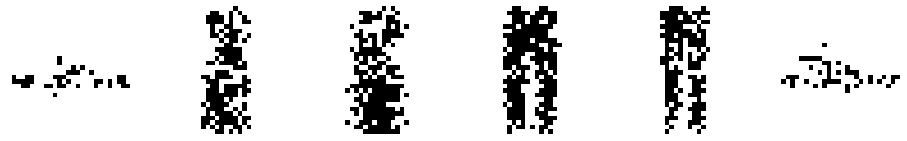

In [18]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [19]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = decoder(z).mean()

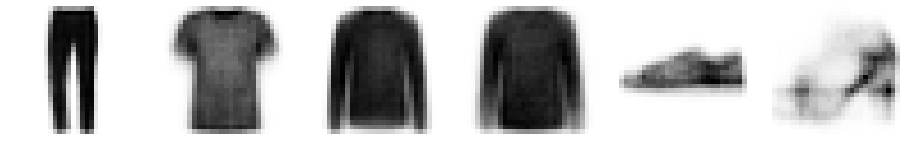

In [20]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

What if we use Monte Carlo Sampling for kl divergence?

In [21]:
encoder = Sequential([
    Flatten(input_shape=event_shape),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2 * latent_size),
    tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :latent_size],
            scale_diag=tf.math.exp(t[..., latent_size:])
        )
    )
])

decoder = Sequential([
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
    tfpl.IndependentBernoulli(event_shape)
])

# Define the prior, p(z) - a standard bivariate Gaussian
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [22]:
def loss(x, encoding_dist, sampled_decoding_dist, prior, sampled_z):
    reconstruction_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z) - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + reconstruction_loss)

In [25]:
@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(x)
        sampled_z = encoding_dist.sample()
        sampled_decoding_dist = decoder(sampled_z)
        current_loss = loss(x, encoding_dist, sampled_decoding_dist, prior, sampled_z)
    grads = tape.gradient(current_loss, encoder.trainable_variables + decoder.trainable_variables)
    return current_loss, grads

In [26]:
# Compile and train the model
num_epochs = 10
optimizer = tf.keras.optimizers.Adam()

for i in range(num_epochs):
    for train_batch in X_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i + 1, current_loss.numpy()))

-ELBO after epoch 1: 8914
-ELBO after epoch 2: 8802
-ELBO after epoch 3: 8799
-ELBO after epoch 4: 8743
-ELBO after epoch 5: 8790
-ELBO after epoch 6: 8716
-ELBO after epoch 7: 8787
-ELBO after epoch 8: 8686
-ELBO after epoch 9: 8650
-ELBO after epoch 10: 8813


In [27]:
# Connect encoder and decoder, compute a reconstruction with mean

def vae_mean(inputs):
    approx_posterior = encoder(inputs)
    decoding_dist = decoder(approx_posterior.sample())
    return decoding_dist.mean()

example_reconstruction = vae_mean(example_X).numpy().squeeze()

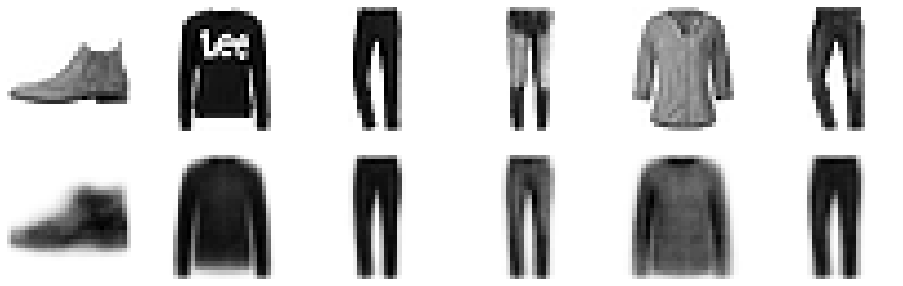

In [28]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_X[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

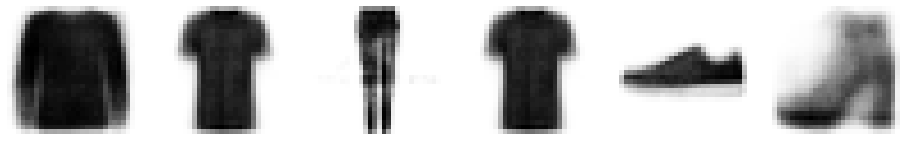

In [29]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z = prior.sample(6)
generated_x = decoder(z).mean()

# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')